In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
sns.set_style('dark')
# %matplotlib

## Import and inital assessment of data

Since we have no idea what this data will be used for classification/prediction generalizing the data can be very hard. I would go so far as to say that since we don't even know what features we might consider to be useful in this dataset, returning the exact same CSV that you sent to us would not be entirely inappropriate. It could equally also make sense to just send back the CSV with features that don't contain nulls/nans. However, I have done my best to do what I think is appropriate.

In [2]:
dirty = pd.read_csv('MetObjects.csv')

C:\Users\Telahun\Anaconda3\envs\chollet\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,8,9,10,11,18,27,28,29,30,31,32,33,34,35,36,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dirty.head()

,Object Number,Is Highlight,Is Public Domain,Object ID,Department,Object Name,Title,Culture,Period,Dynasty,...,Locale,Locus,Excavation,River,Classification,Rights and Reproduction,Link Resource,Metadata Date,Repository,Tags
0,1979.486.1,False,False,1,The American Wing,Coin,One-dollar Liberty Head Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,"Metropolitan Museum of Art, New York, NY",NaN
1,1980.264.5,False,False,2,The American Wing,Coin,Ten-dollar Liberty Head Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,"Metropolitan Museum of Art, New York, NY",NaN
2,67.265.9,False,False,3,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,"Metropolitan Museum of Art, New York, NY",NaN
3,67.265.10,False,False,4,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,"Metropolitan Museum of Art, New York, NY",NaN
4,67.265.11,False,False,5,The American Wing,Coin,Two-and-a-Half Dollar Coin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,"Metropolitan Museum of Art, New York, NY",NaN


In [4]:
print(dirty.info())
print(dirty.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473770 entries, 0 to 473769
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Object Number            473770 non-null  object
 1   Is Highlight             473770 non-null  bool  
 2   Is Public Domain         473770 non-null  bool  
 3   Object ID                473770 non-null  int64 
 4   Department               473770 non-null  object
 5   Object Name              471861 non-null  object
 6   Title                    443804 non-null  object
 7   Culture                  206214 non-null  object
 8   Period                   88762 non-null   object
 9   Dynasty                  23134 non-null   object
 10  Reign                    11160 non-null   object
 11  Portfolio                23036 non-null   object
 12  Artist Role              269705 non-null  object
 13  Artist Prefix            88981 non-null   object
 14  Artist Display Name 

In [5]:
print(dirty.keys())
print(dirty.iloc[:,4].values)

Index(['Object Number', 'Is Highlight', 'Is Public Domain', 'Object ID',
       'Department', 'Object Name', 'Title', 'Culture', 'Period', 'Dynasty',
       'Reign', 'Portfolio', 'Artist Role', 'Artist Prefix',
       'Artist Display Name', 'Artist Display Bio', 'Artist Suffix',
       'Artist Alpha Sort', 'Artist Nationality', 'Artist Begin Date',
       'Artist End Date', 'Object Date', 'Object Begin Date',
       'Object End Date', 'Medium', 'Dimensions', 'Credit Line',
       'Geography Type', 'City', 'State', 'County', 'Country', 'Region',
       'Subregion', 'Locale', 'Locus', 'Excavation', 'River', 'Classification',
       'Rights and Reproduction', 'Link Resource', 'Metadata Date',
       'Repository', 'Tags'],
      dtype='object')
['The American Wing' 'The American Wing' 'The American Wing' ...
 'Drawings and Prints' 'Drawings and Prints' 'Drawings and Prints']


# 1. Create a table with all the features in the dataset with their expected data type. 

- The first thing that should be mentioned comes from the warning when importing the data: Columns (7,8,9,10,11,18,27,28,29,30,31,32,33,34,35,36,37,39) have mixed types. The only column with strictly numerical data is the Object Id which could be used as the Object number as it is unique to each peice. I would replace/remove the Object number because it has missing values and the format for different objects seems to vary. There are some features that have both numerical and categorical values, for example Artist Suffix has values like (1896, London, & Co.). I have left features like this as categorical because it looks like the numerical value is meant to be categorical. This could be wrong this is just my interpertation. 


- There are columns which have dates. I have included these as "categorical date" for the data type of the feature as we can categorize objects based on the days they were created, procured, found, etc. Although dates are continuous in nature I am assuming these are meant to be categorically used but they could be used for a timeseries if needed. Again this is my interperation.

In [6]:
valuesAndType = pd.DataFrame({"Keys": dirty.keys(), "Types": dirty.dtypes})
valuesAndType.index=[np.arange(44)]

In [7]:
valuesAndType["Types"] = ["categorical" if ele == "object" else ele for ele in valuesAndType["Types"]]
date = "Date"
valuesAndType["Types"] = ["categorical date" if re.search(date, ele) else typ for ele, typ in zip(valuesAndType["Keys"], valuesAndType["Types"])]
valuesAndType

,Keys,Types
0,Object Number,categorical
1,Is Highlight,bool
2,Is Public Domain,bool
3,Object ID,int64
4,Department,categorical
5,Object Name,categorical
6,Title,categorical
7,Culture,categorical
8,Period,categorical
9,Dynasty,categorical


# 2. Obtain the basic statistical analysis for all numerical features.

- Again, the only column with strictly numerical data is the Object Id. This appears to be something like an index for the website link to the sub-domain for the specific object. It has all unique values but the numbers are not contiguous so objects must have been moved/stolen/removed from the Met. Theres nothing special about this row to plot or infer. I included "Object Number" just for completeness.

In [8]:
# dirty = dirty.drop(["Object Number"], axis=1)
dirty["Object ID"]

0              1
1              2
2              3
3              4
4              5
           ...  
473765    843221
473766    843222
473767    843223
473768    843227
473769    843228
Name: Object ID, Length: 473770, dtype: int64

In [9]:
dirty["Object Number"]

0         1979.486.1
1         1980.264.5
2           67.265.9
3          67.265.10
4          67.265.11
             ...    
473765    58.638.350
473766    58.638.351
473767    58.638.352
473768    67.630.112
473769    42.119.496
Name: Object Number, Length: 473770, dtype: object

# 3. Obtain the basic statistical analysis for all categorical features.

In [10]:
columns = ['Object Number', 'Is Highlight', 'Is Public Domain', 'Object ID',
       'Department', 'Object Name', 'Title', 'Culture', 'Period', 'Dynasty',
       'Reign', 'Portfolio', 'Artist Role', 'Artist Prefix',
       'Artist Display Name', 'Artist Display Bio', 'Artist Suffix',
       'Artist Alpha Sort', 'Artist Nationality', 'Artist Begin Date',
       'Artist End Date', 'Object Date', 'Object Begin Date',
       'Object End Date', 'Medium', 'Dimensions', 'Credit Line',
       'Geography Type', 'City', 'State', 'County', 'Country', 'Region',
       'Subregion', 'Locale', 'Locus', 'Excavation', 'River', 'Classification',
       'Rights and Reproduction', 'Link Resource', 'Metadata Date',
       'Repository', 'Tags']

## Boolean Features
*----------------------------------------------------------------------------------------------*

- Here are the boolean features which I included under categorical. The features are "Is Highlight", "Is Public Domain".
    - The Is Highlight feature I believe could be an indicator that it is significant like a highlight peice on display.
    - The "Is Public Domain" appears to be whether or not an object has an image on the website.
        - http://www.metmuseum.org/art/collection/search/1
        - http://www.metmuseum.org/art/collection/search/38
    
    
 - These two features have no blanks and are well formed

In [11]:
def pd_counts_plotter(data, title, x_title, y_title, bi=0):
    if bi > 0:
        ax = data.value_counts().plot.hist(bins=bi, color="teal", figsize=(15,8), fontsize=14)
    else:
        ax = data.value_counts().plot.bar(color="teal", figsize=(15,8), fontsize=14)

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(x_title, fontsize=18);
    ax.set_ylabel(y_title, fontsize=18);


    for i in ax.patches:
        ax.text(i.xy[0]+0.2, (i.get_height()+0.2), i.get_height(), fontsize=15, color='black')

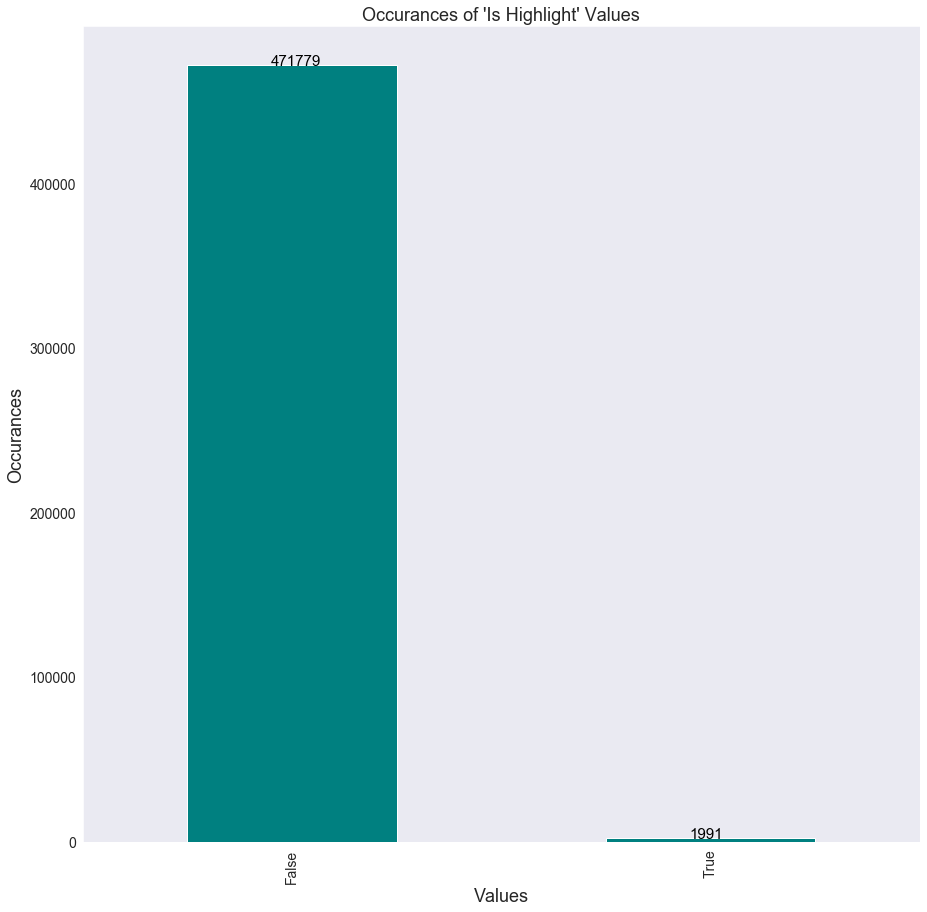

In [12]:
pd_counts_plotter(dirty["Is Highlight"], "Occurances of 'Is Highlight' Values", "Values", "Occurances")

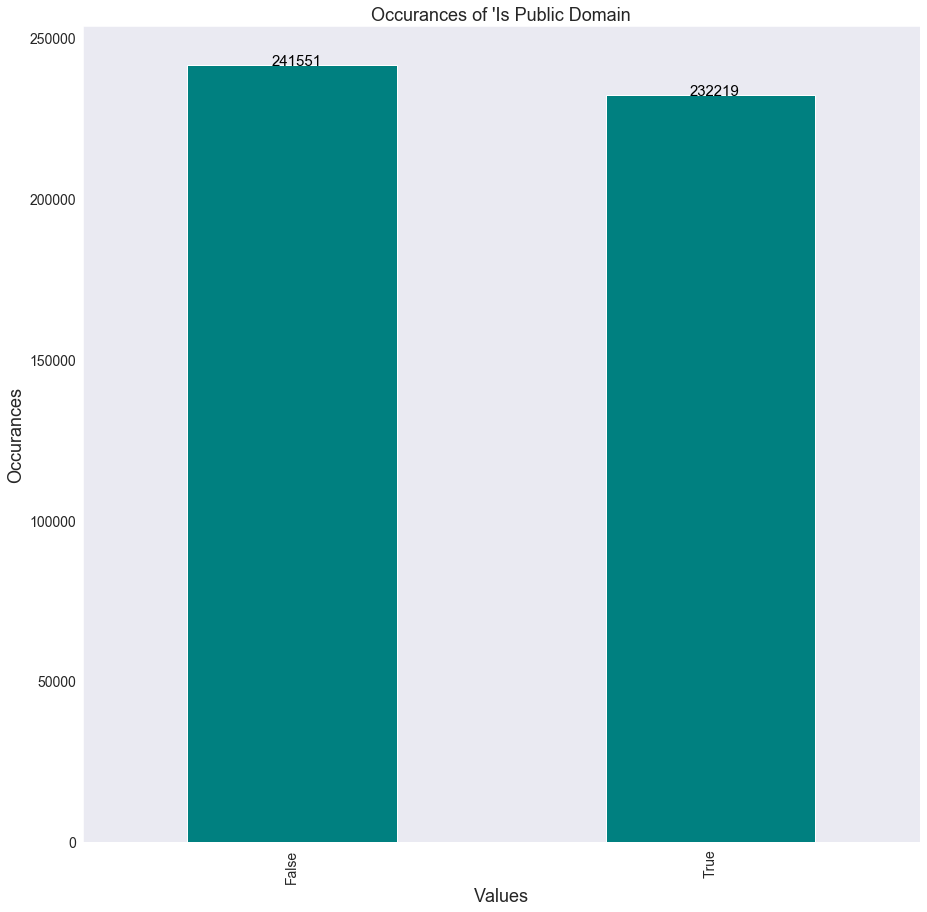

In [13]:
pd_counts_plotter(dirty["Is Public Domain"], "Occurances of 'Is Public Domain", "Values", "Occurances")

## Date Features
*----------------------------------------------------------------------------------------------*
- I'm going to store any values that could be null/weird as "UNKNOWN" so if they are ever needed I can keep track of them 

In [14]:
def ensure_dates(feature, frame, regexp, compare, both=False, castType="int32"):
    '''This will replace the weird/null values as "UNKNOWN" and then ensure the data can be processed as whatever
    type we want to use. Takes a series or feature, the dataframe with that feature, a complied regex expression, 
    a comparison value, and the final cast type of the series/feature.'''
    frame[feature] = frame[feature].fillna("UNKNOWN")
    frame[feature] = frame[feature].apply(lambda x : re.findall(regexp, str(x))[0] \
                                          if re.findall(regexp, str(x)) else "UNKNOWN")
    
    df = pd.DataFrame({"Object ID": frame["Object ID"], feature: frame[feature]})
    idx = df[df[feature] == "UNKNOWN"].index
    df.drop(idx, inplace=True)
    
    if both:
        idx = df[df[feature] > compare].index
        df.drop(idx, inplace=True)
        compare = int(compare)

    if isinstance(compare, int):
        df[feature] = pd.to_numeric(df[feature], errors='coerce')

    idx = df[df[feature] > compare].index
    df.drop(idx, inplace=True)

    df = df.loc[df[feature].notnull()]
    df[feature] = df[feature].astype(castType)
    print("Unique " + feature + "s: " + str(len(df[feature].unique())))

    return df

In [23]:
dateFeatures = dirty[['Object ID', 'Artist Begin Date', 'Artist End Date', 'Object Date', 'Object Begin Date', 'Object End Date', 'Metadata Date']].copy()
dateFeatures

,Object ID,Artist Begin Date,Artist End Date,Object Date,Object Begin Date,Object End Date,Metadata Date
0,1,1794,1869,1853,1853,1853,NaN
1,2,1785,1844,1901,1901,1901,NaN
2,3,NaN,NaN,1909–27,1909,1927,NaN
3,4,NaN,NaN,1909–27,1909,1927,NaN
4,5,NaN,NaN,1909–27,1909,1927,NaN
...,...,...,...,...,...,...,...
473765,843221,1830,1890,ca. 1830–70,1825,1875,2020-02-22T04:41:27.847Z
473766,843222,1830,1890,ca. 1830–70,1825,1875,2020-02-22T04:41:27.847Z
473767,843223,1830,1890,ca. 1830–70,1825,1875,2020-02-22T04:41:27.847Z
473768,843227,1727 |1862,1788 |1938,1896–1923,1896,1923,2020-02-22T04:41:27.847Z


### Metadata Date
*----------------------------------------------------------------------------------------------*

In [24]:
onlyYYYYMMDD = r"\d{1,}-\d{1,}-\d{1,}"
regexp = re.compile(onlyYYYYMMDD)

In [25]:
# dateFeatures["Metadata Date"] = dateFeatures["Metadata Date"].apply(lambda x : re.findall(regexp , str(x))[0] if re.findall(regexp , str(x)) else "UNKNOWN")
# dateFeatures["Metadata Date"]

In [26]:
# dateFeatures["Metadata Date"] = dateFeatures["Metadata Date"].fillna("UNKNOWN")

# # dateFeatures["Metadata Date"] = [re.findall(regexp, str(ele))[0] if len(ele) > 1 else "UNKNOWN" \
# #                                      for ele in dateFeatures["Metadata Date"]]


# for i, ele in enumerate(dateFeatures["Metadata Date"]):
#     if ele is not "UNKNOWN":
#         ele = re.findall(regexp, str(ele))[0] 
#         dateFeatures["Metadata Date"][i] = ele
#     else:
#         dateFeatures["Metadata Date"][i] = "UNKNOWN"

# dateFeatures["Metadata Date"]

In [27]:
md = ensure_dates("Metadata Date", dateFeatures, regexp, "2021", castType="datetime64")
md

Unique Metadata Dates: 413


,Object ID,Metadata Date
6,7,2019-02-01
7,8,2019-07-31
32,33,2019-07-31
33,34,2019-10-10
34,35,2019-04-27
...,...,...
473765,843221,2020-02-22
473766,843222,2020-02-22
473767,843223,2020-02-22
473768,843227,2020-02-22


In [28]:
# print("Unique Metadata Dates: " + str(len(dateFeatures["Metadata Date"].unique())))

# md = pd.DataFrame({"Object ID":dateFeatures["Object ID"], "Metadata_Date":dateFeatures["Metadata Date"]})
# idx = md[md['Metadata_Date'] == "UNKNOWN"].index
# md.drop(idx, inplace=True)

# idx = md[md['Metadata_Date'] > "2021"].index
# md.drop(idx, inplace=True)

# print("Unique Artist Begin Dates: " + str(len(md["Metadata_Date"].unique())))

# # pd.to_datetime(md['Metadata_Date'], format='%Y')
# # aed["Artist_End_Date"] = aed["Artist_End_Date"].astype(df.Year, format='%Y')
# md['Metadata_Date'] = md['Metadata_Date'].astype("datetime64")
# md


####
# abd['Artist_Begin_Date'] = pd.to_numeric(abd['Artist_Begin_Date'], errors='coerce')

# idx = abd[abd['Artist_Begin_Date'] > 2020].index
# abd.drop(idx, inplace=True)

# abd = abd.loc[abd['Artist_Begin_Date'].notnull()]
# aed['Artist_Begin_Date'] = abd['Artist_Begin_Date'].astype("int32")
# print("Unique Artist Begin Dates: " + str(len(abd["Artist_Begin_Date"].unique())))



# md['Metadata_Date'].unique()
# pd_counts_plotter(md['Metadata_Date'], "title", "x_title", "y_title", bi=110)

### Artist Begin Date
*----------------------------------------------------------------------------------------------*

In [29]:
onlyNumber = r"\d{4}"
regexp = re.compile(onlyNumber)

In [30]:
# dateFeatures["Artist Begin Date"] = dateFeatures["Artist Begin Date"].fillna("UNKNOWN")
# dateFeatures["Artist Begin Date"] = dateFeatures["Artist Begin Date"].apply(lambda x : re.findall(regexp , str(x))[0] if re.findall(regexp , str(x)) else "UNKNOWN")
# dateFeatures["Artist Begin Date"]

In [31]:
# dateFeatures["Artist Begin Date"] = dateFeatures["Artist Begin Date"].fillna("UNKNOWN")

# # dateFeatures["Artist Begin Date"] = [re.findall(regexp, str(ele))[0] if regexp.search(ele) else "UNKNOWN" \
# #                                      for ele in dateFeatures["Artist Begin Date"]]

# for i, ele in enumerate(dateFeatures["Artist Begin Date"]):
#     if ele is not "UNKNOWN":
#         ele = re.findall(regexp, str(ele))[0] 
#         dateFeatures["Artist Begin Date"][i] = ele
#     else:
#         dateFeatures["Artist Begin Date"][i] = "UNKNOWN"

# dateFeatures["Artist Begin Date"]

In [32]:
abd = ensure_dates("Artist Begin Date", dateFeatures, regexp, 2020)
abd

Unique Artist Begin Dates: 867


,Object ID,Artist Begin Date
0,1,1794
1,2,1785
9,10,1867
10,11,1785
11,12,1794
...,...,...
473765,843221,1830
473766,843222,1830
473767,843223,1830
473768,843227,1727


In [33]:
# abd = pd.DataFrame({"Object ID": dateFeatures["Object ID"],"Artist_Begin_Date":dateFeatures["Artist Begin Date"]})
# idx = abd[abd['Artist_Begin_Date'] == "UNKNOWN"].index
# abd.drop(idx, inplace=True)

# abd['Artist_Begin_Date'] = pd.to_numeric(abd['Artist_Begin_Date'], errors='coerce')

# idx = abd[abd['Artist_Begin_Date'] > 2020].index
# abd.drop(idx, inplace=True)

# abd = abd.loc[abd['Artist_Begin_Date'].notnull()]
# abd['Artist_Begin_Date'] = abd['Artist_Begin_Date'].astype("int32")
# print("Unique Artist Begin Dates: " + str(len(abd["Artist_Begin_Date"].unique())))

# abd
# df.groupby(dateFeatures["Artist End DateC"].dt.year).count().plot(kind="bar")
# pd_counts_plotter(aed["Artist_End_Date"], "title", "x_title", "y_title", bi=50)

### Artist End Date
*----------------------------------------------------------------------------------------------*

In [35]:
# dateFeatures["Artist End Date"] = dateFeatures["Artist End Date"].fillna("UNKNOWN")

# for i, ele in enumerate(dateFeatures["Artist End Date"]):
#     if ele is not "UNKNOWN":
#         ele = re.findall(regexp, str(ele))[0] 
#         dateFeatures["Artist End Date"][i] = ele
#     else:
#         dateFeatures["Artist End Date"][i] = "UNKNOWN" 
        
# dateFeatures["Artist End Date"]

In [36]:
aed = ensure_dates("Artist End Date", dateFeatures, regexp, "2020",both=True)
aed

Unique Artist End Dates: 824


,Object ID,Artist End Date
0,1,1869
1,2,1844
9,10,1917
10,11,1844
11,12,1869
...,...,...
473765,843221,1890
473766,843222,1890
473767,843223,1890
473768,843227,1788


In [79]:
# aed = pd.DataFrame({"Object ID": dateFeatures["Object ID"],"Artist_End_Date":dateFeatures["Artist End Date"]})
# idx = aed[aed['Artist_End_Date'] == "UNKNOWN"].index
# aed.drop(idx, inplace=True)

# idx = aed[aed['Artist_End_Date'] > "2020"].index
# aed.drop(idx, inplace=True)

# aed['Artist_End_Date'] = pd.to_numeric(aed['Artist_End_Date'], errors='coerce')

# idx = aed[aed['Artist_End_Date'] > 2020].index
# aed.drop(idx, inplace=True)

# aed = aed.loc[aed['Artist_End_Date'].notnull()]
# aed['Artist_End_Date'] = aed['Artist_End_Date'].astype("int32")
# print("Unique Artist End Dates: " + str(len(aed["Artist_End_Date"].unique())))

# # pd_counts_plotter(aed["Artist_End_Date"], "title", "x_title", "y_title", bi=50)

# aed

Unique Artist End Dates: 824


,Object ID,Artist_End_Date
0,1,1869
1,2,1844
9,10,1917
10,11,1844
11,12,1869
...,...,...
473765,843221,1890
473766,843222,1890
473767,843223,1890
473768,843227,1788


### Object Begin Date
*----------------------------------------------------------------------------------------------*

In [24]:
# dateFeatures["Object Begin Date"] = dateFeatures["Object Begin Date"].fillna("UNKNOWN")

# for i, ele in enumerate(dateFeatures["Object Begin Date"]):
#     if ele is not "UNKNOWN":
#         ele = re.findall(regexp, str(ele))[0] 
#         dateFeatures["Object Begin Date"][i] = ele
#     else:
#         dateFeatures["Object Begin Date"][i] = "UNKNOWN"
        
# dateFeatures["Object Begin Date"]

C:\Users\Telahun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Telahun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0         1853
1         1901
2         1909
3         1909
4         1909
          ... 
473765    1825
473766    1825
473767    1825
473768    1896
473769       0
Name: Object Begin Date, Length: 473770, dtype: object

In [37]:
obd = ensure_dates("Object Begin Date", dateFeatures, regexp, 2020)
obd

Unique Object Begin Dates: 893


,Object ID,Object Begin Date
0,1,1853
1,2,1901
2,3,1909
3,4,1909
4,5,1909
...,...,...
473764,843219,1825
473765,843221,1825
473766,843222,1825
473767,843223,1825


In [31]:
# obd = pd.DataFrame({"Object ID":dateFeatures["Object ID"], "Object_Begin_Date":dateFeatures["Object Begin Date"]})
# idx = obd[obd['Object_Begin_Date'] == "UNKNOWN"].index
# obd.drop(idx, inplace=True)

# obd['Object_Begin_Date'] = pd.to_numeric(obd['Object_Begin_Date'], errors='coerce')


# idx = obd[obd['Object_Begin_Date'] > 2020].index
# obd.drop(idx, inplace=True)



# obd = obd.loc[obd['Object_Begin_Date'].notnull()]

# # oed["Object_End_Date"] = oed["Object_End_Date"].dropna()
# obd['Object_Begin_Date'] = obd['Object_Begin_Date'].astype("int32")

# print("Unique Object Begin Dates: " + str(len(obd["Object_Begin_Date"].unique())))

# pd_counts_plotter(dateFeatures["Object Begin Date"], "title", "x_title", "y_title", bi=410)

# obd

Unique Object Begin Dates: 1315


,Object ID,Object_Begin_Date
0,1,1853
1,2,1901
2,3,1909
3,4,1909
4,5,1909
...,...,...
473765,843221,1825
473766,843222,1825
473767,843223,1825
473768,843227,1896


### Object End Date
*----------------------------------------------------------------------------------------------*

In [26]:
# dateFeatures["Object End Date"] = dateFeatures["Object End Date"].fillna("UNKNOWN")

# for i, ele in enumerate(dateFeatures["Object End Date"]):
#     if ele is not "UNKNOWN":
#         ele = re.findall(regexp, str(ele))[0] 
#         dateFeatures["Object End Date"][i] = ele
#     else:
#         dateFeatures["Object End Date"][i] = "UNKNOWN"
        
# dateFeatures["Object End Date"]

C:\Users\Telahun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0         1853
1         1901
2         1927
3         1927
4         1927
          ... 
473765    1875
473766    1875
473767    1875
473768    1923
473769       0
Name: Object End Date, Length: 473770, dtype: object

In [38]:
oed = ensure_dates("Object End Date", dateFeatures, regexp, 2020)
oed

Unique Object End Dates: 889


,Object ID,Object End Date
0,1,1853
1,2,1901
2,3,1927
3,4,1927
4,5,1927
...,...,...
473764,843219,1875
473765,843221,1875
473766,843222,1875
473767,843223,1875


In [32]:
# oed = pd.DataFrame({"Object ID" : dateFeatures["Object ID"],"Object_End_Date":dateFeatures["Object End Date"]})
# idx = oed[oed['Object_End_Date'] == "UNKNOWN"].index
# oed.drop(idx, inplace=True)

# oed['Object_End_Date'] = pd.to_numeric(oed['Object_End_Date'], errors='coerce')

# idx = oed[oed['Object_End_Date'] > 2020].index
# oed.drop(idx, inplace=True)


# oed = oed.loc[oed['Object_End_Date'].notnull()]

# # oed["Object_End_Date"] = oed["Object_End_Date"].dropna()
# oed['Object_End_Date'] = oed['Object_End_Date'].astype("int32")


# print("Unique Object End Dates: " + str(len(oed["Object_End_Date"].unique())))

# # Cannot convert non-finite values (NA or inf) to integer
# # pd_counts_plotter(oed["Object_End_Date"], "title", "x_title", "y_title", bi=50)

# oed

Unique Object End Dates: 1294


,Object ID,Object_End_Date
0,1,1853
1,2,1901
2,3,1927
3,4,1927
4,5,1927
...,...,...
473765,843221,1875
473766,843222,1875
473767,843223,1875
473768,843227,1923


### "Object Date"
- It is my opinion that we should drop the feature "Object Date", although it does contain decient information about the records that are there, the reasons for this:
    - It has a very different format from the other dates i.e it contains not only dates but descriptions of time periods
    - Other records in this feature contain an odd combination of ca, BC, and AD sometimes all in one record making those records useless
    - It confuses the meaning and purpose of the already well formed "Object Begin/End Date" features
    - Here are some records that caught my attention as misleading and again we have clear and well formed features for "Object Begin/End Date" features
        - armet, ca. 1460–70; wrapper, ca. 1450; rondel, probably 18th–19th century
        - A.H. 1242/ A.D. 1826–27
        - 5th century or earlier
        - Year of the Dragon, probably 1832
        - ca. 10,000 B.C.–5000 B.C.

In [74]:
# dateFeatures = dateFeatures.drop(["Object Date"], axis=1)

## New Date features or Date Table:

In [39]:
dfs = [abd, aed, obd, oed, md]
cDateFeatures = reduce(lambda left,right: pd.merge(left,right,on='Object ID'), dfs)
cDateFeatures

,Object ID,Artist Begin Date,Artist End Date,Object Begin Date,Object End Date,Metadata Date
0,33,1861,1930,1876,1876,2019-07-31
1,34,1835,1853,1847,1850,2019-10-10
2,35,1859,1927,1893,1895,2019-04-27
3,36,1885,1932,1884,1887,2019-07-26
4,37,1765,1795,1782,1785,2019-02-01
...,...,...,...,...,...,...
159152,843219,1830,1890,1825,1875,2020-02-22
159153,843221,1830,1890,1825,1875,2020-02-22
159154,843222,1830,1890,1825,1875,2020-02-22
159155,843223,1830,1890,1825,1875,2020-02-22


## Text Features
*----------------------------------------------------------------------------------------------*

- Here are the unique values for each column. I'm going to remove the feature "Link Resource" right away from strings because they don't help understand the data right now for the categorical features. Link Resource is the link to the object at the Met where the sub-domain is /ObjectID.
- I will remove "Geography Type" because there are a lot of "Probably's" in there so the data seems to be useless although it could be used if trying to add discreptive text to a query. This is probably used on the website when its available.
- For a similar reason as geography I will remove "Credit Line" it is nice additional discreptive text but probably used for the website when its there.


- I would remove "Rights and Reproduction" since 95% of these are missing although it important since it is only collected for a small portion of the records I would omit it for the time being
- Omit
    - "Object Name" because it is just the "prefix" of the "Title" so having it makes the data more busy to understand.
    - "Portfolio" because it is less than 4% of the data, I don't think it adds value to the bulk of the data that exists. However, it is nice descriptive text like for a website.
    - "Repository" since we know were looking at the Met Dataset and they are all "Metropolitan Museum of Art, New York, NY"
    - "Artist Prefix", "Artist Suffix", "Artist Alpha Sort" again because they are additional explanitory text that I don't think is needed but good for a website.
    - "Artist Display Bio" because they are not easily read and are essentially a combination of one of the Artist Dates and their Nationality.
    
    
- I am going to leave "Department", "Object Name", "Title", "Culture", "Period", "Dynasty", "Reign"(25%), "Artist Role", "Artist Display Name, "Artist Nationality"(25%), "Medium", "Dimensions", "Classification", "Tags" as they are because they appear to be well formed and pipe delimited so changing that will make no difference.
    - With "Period", "Dynasty", "Reign"(~25%) I think it is clear enough in the data that at least 1 of these is good enough.
        - Adding "Artist Nationality"
    - Each of these features be checked for weird/null values that should be cleaned but nothing over the top.
    - I think it is safe to say that additional processing for somee if not all of these features is definitly required but that depends on the use case.
    
    
- From the features: 'City', 'State', 'County', 'Country', 'Region','Subregion', 'Locale', 'Locus', 'Excavation', 'River' I chose to sperate these because we could have a table very sperate that has data about the location of the peice. However, the only column with more than 5% of the records is "Country" with about 10%.
    - After reevaluating this later I have decided to drop this table because the data is very sparse. It is also a little confusing when they differ from other descriptive features i.e. Author Nationality, Dynasty, and Culture.

In [376]:
def key_val_plotter(dictionary, df, orient="vertical"):
    for key, val in dictionary.items():
        dictionary[key]= df[key].notna().sum()
        print(str(key) + " <" + str(dictionary[key]) + ">")
        
    f, ax = plt.subplots(figsize=(25,15))
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center', color='teal',orientation=orient)
    plt.xticks(range(len(dictionary)), list(dictionary.keys()), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [352]:
textColumns = ['Object ID', 'Department', 'Title', 'Culture', 'Period', 'Dynasty','Reign', 
               'Artist Role', 'Artist Display Name', 'Artist Nationality', 'Medium', 'Dimensions', 'Classification',  'Tags']

In [353]:
localColumns = ['Object ID','City', 'State', 'County', 'Country', 'Region',
       'Subregion', 'Locale', 'Locus', 'Excavation', 'River']

In [354]:
textFeatures = dirty[textColumns].copy()

Object ID <473770>
Department <473770>
Title <443804>
Culture <206214>
Period <88762>
Dynasty <23134>
Reign <11160>
Artist Role <269705>
Artist Display Name <271799>
Artist Nationality <182497>
Medium <466597>
Dimensions <398182>
Classification <417772>
Tags <220460>


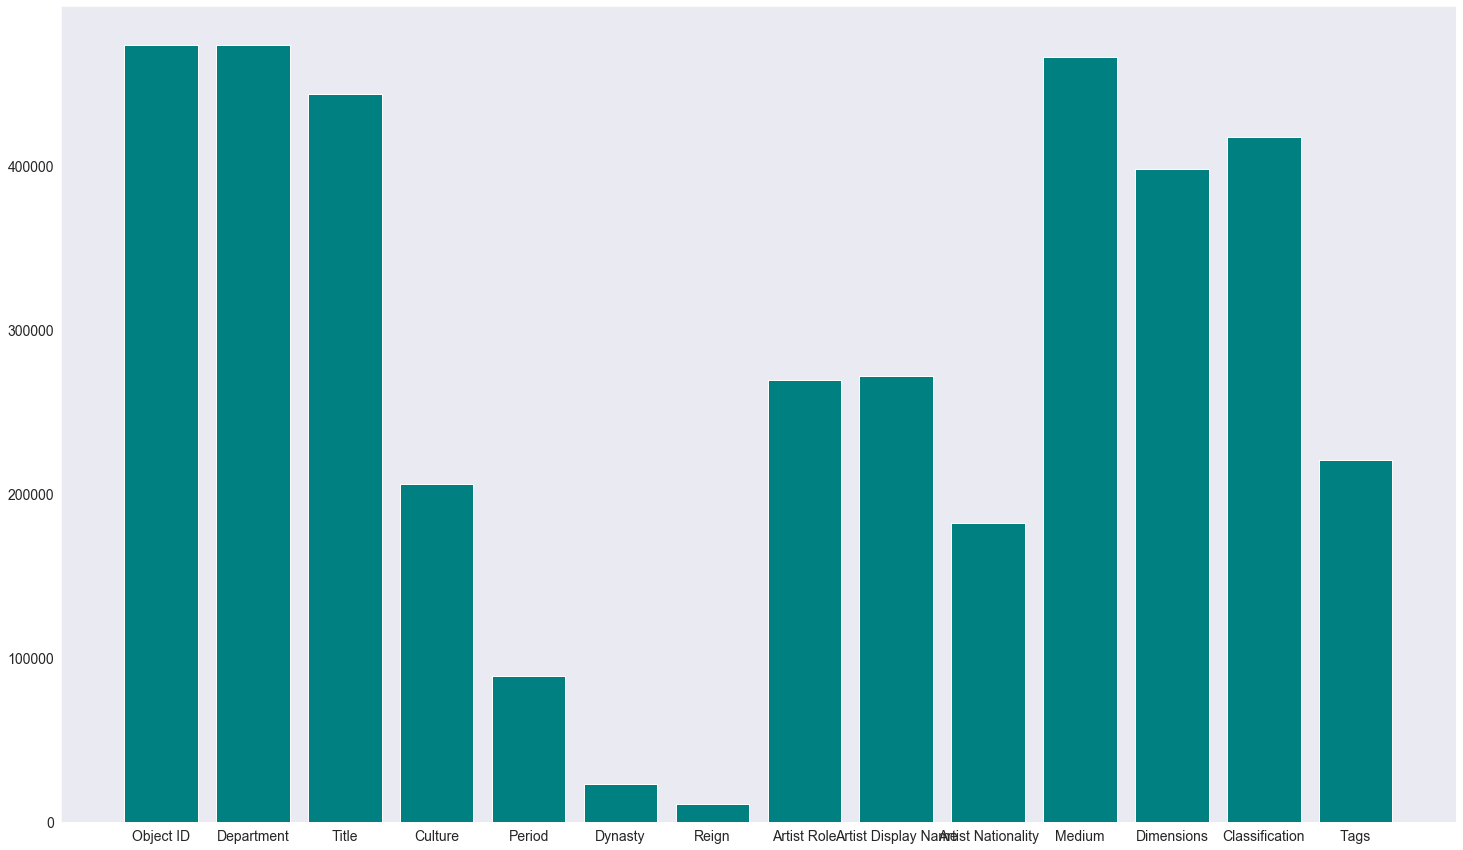

In [356]:
featCount = { i : 0 for i in textFeatures.keys() }
key_val_plotter(featCount,textFeatures)

Object ID <347359>
Department <347359>
Title <347359>
Culture <124688>
Period <27795>
Dynasty <2477>
Reign <757>
Artist Role <230455>
Artist Display Name <231604>
Artist Nationality <149955>
Medium <347359>
Dimensions <347359>
Classification <347359>
Tags <179190>


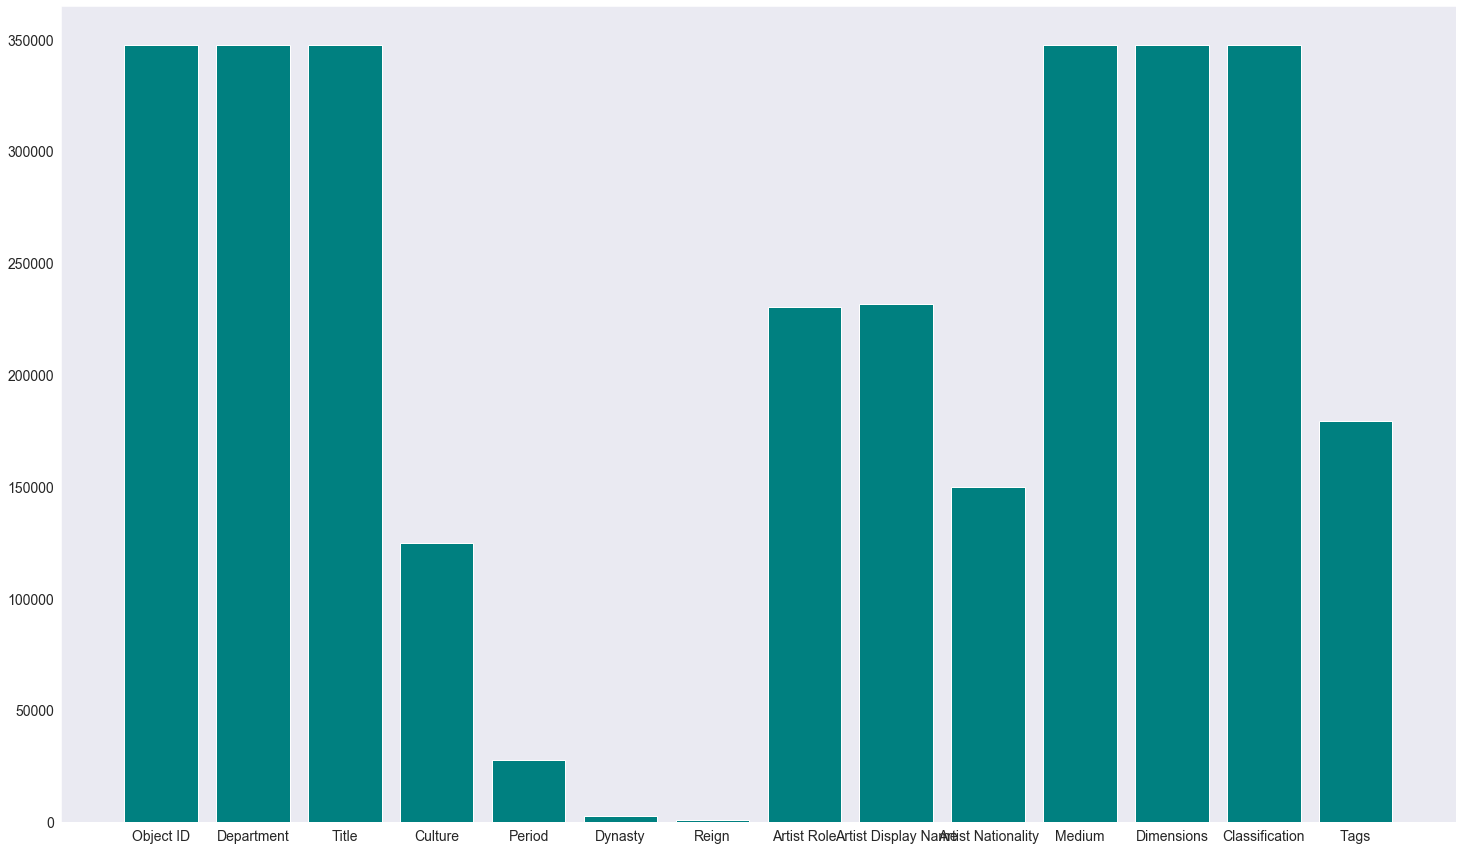

In [357]:
textFeatures = textFeatures.dropna(how='any', subset=['Department', 'Title', 'Medium', 'Classification', 'Dimensions'])
featCount = { i : 0 for i in textFeatures.keys() }
key_val_plotter(featCount,textFeatures)

Object ID <261595>
Department <261595>
Title <261595>
Culture <124688>
Period <27795>
Dynasty <2477>
Reign <757>
Artist Role <165789>
Artist Display Name <166937>
Artist Nationality <149955>
Medium <261595>
Dimensions <261595>
Classification <261595>
Tags <141459>


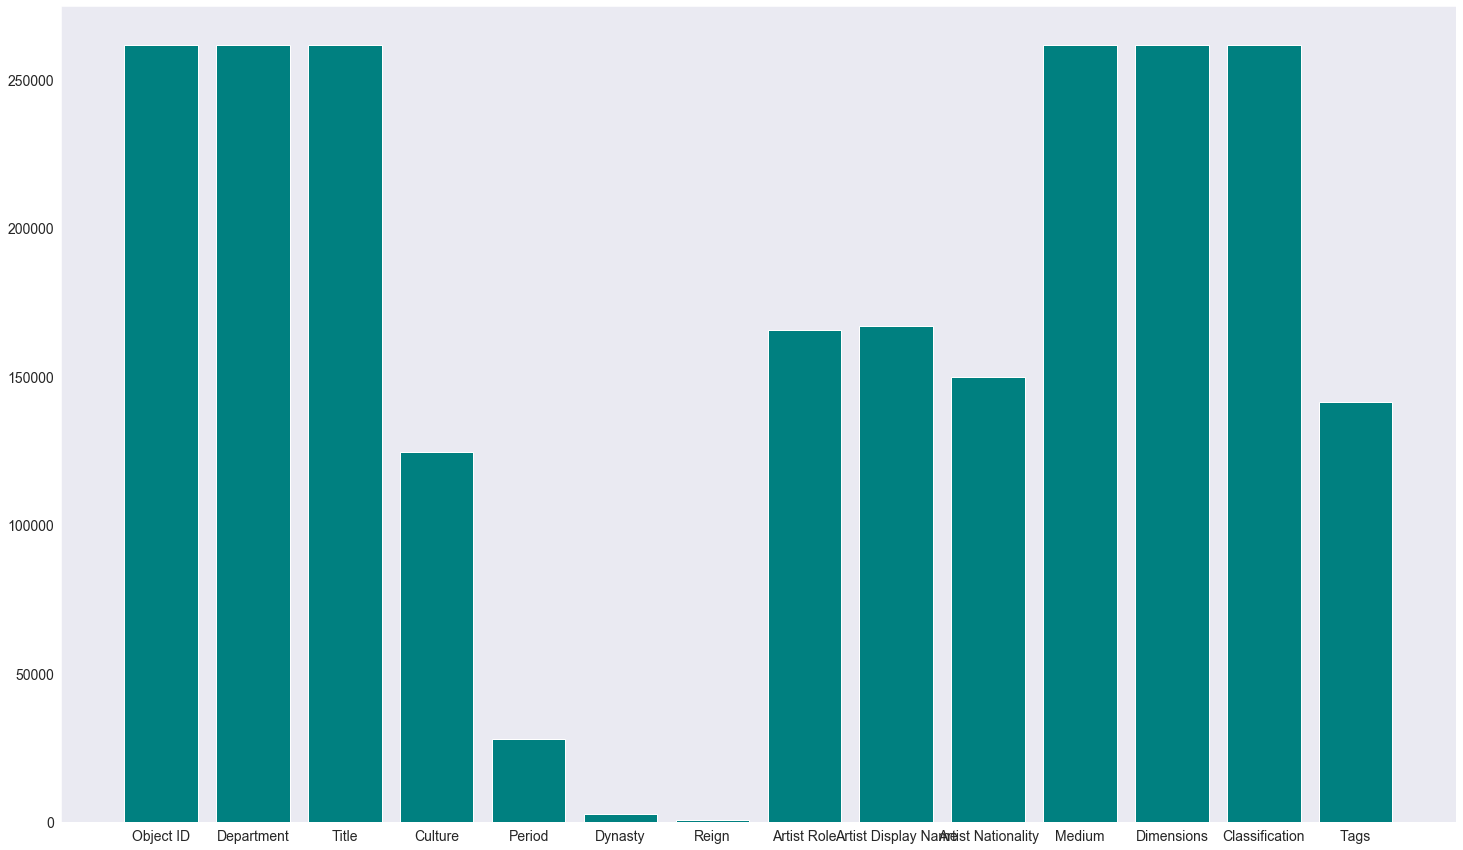

In [358]:
textFeatures = textFeatures.dropna(how='all', subset=['Culture', 'Period', 'Dynasty','Reign', 'Artist Nationality'])
featCount = { i : 0 for i in textFeatures.keys() }
key_val_plotter(featCount,textFeatures)

- From the above filtering the changes in records were as following:
    - 473770 <>
    - 441913 <> Title
    - 435268 <> Medium
    - 379520 <> Classification
    - 345890 <> Dimensions
    - 261595 <> Culture, Period, Artist Nationality

- We are left with 261,595 rows after droping rows that "Cannot" be NAN and rows based on groups of features that "Cannot" all be NAN
- We kept rows with any value that is not nan for 'Culture', 'Period', 'Dynasty','Reign', 'Artist Nationality'
    - Here is a plot of the number of values in each of those columns

Culture <124688>
Period <27795>
Dynasty <2477>
Reign <757>
Artist Nationality <149955>


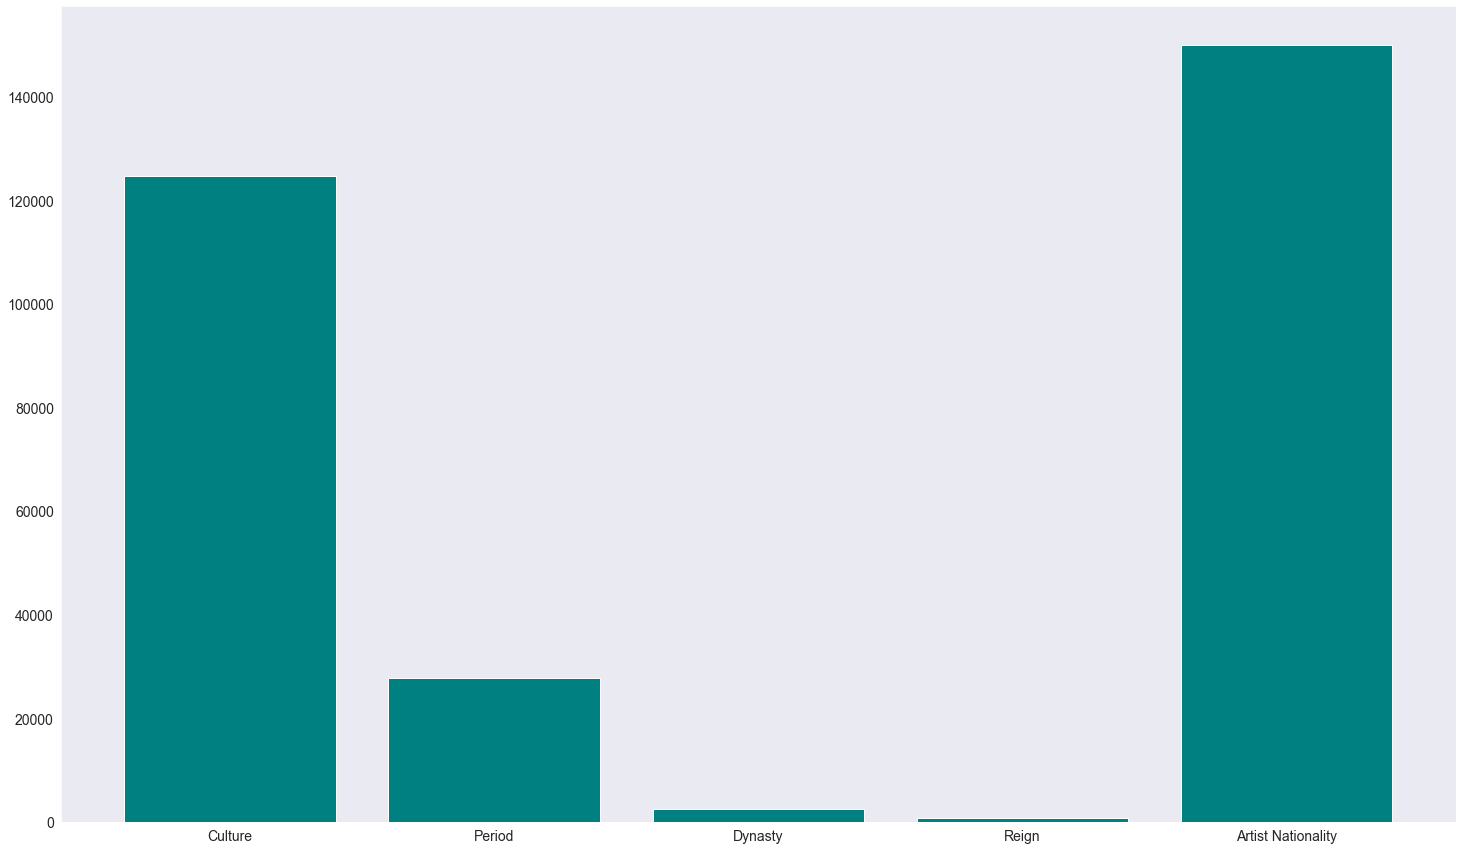

In [359]:
featCount = {'Culture': 0, 'Period': 0, 'Dynasty': 0,'Reign': 0, 'Artist Nationality': 0}
key_val_plotter(featCount, textFeatures)

- Since Period, Dynasty, and Reign have significantly decreased after the previous steps I will drop them as they are very insignificant

In [360]:
textFeatures = textFeatures.drop(['Period', 'Dynasty','Reign'], axis=1)
textFeatures.head()

,Object ID,Department,Title,Culture,Artist Role,Artist Display Name,Artist Nationality,Medium,Dimensions,Classification,Tags
0,1,The American Wing,One-dollar Liberty Head Coin,NaN,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,NaN
11,12,The American Wing,Twenty-dollar Liberty Head Coin,NaN,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,NaN
14,15,The American Wing,"Coin, 1/2 Real",Mexican,NaN,NaN,NaN,Silver,Diam. 1/2 in. (1.3 cm),Silver,NaN
15,16,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,NaN,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,NaN
16,17,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,NaN,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,NaN


Object ID <261595>
Department <261595>
Title <261595>
Culture <124688>
Artist Role <165789>
Artist Display Name <166937>
Artist Nationality <149955>
Medium <261595>
Dimensions <261595>
Classification <261595>
Tags <141459>


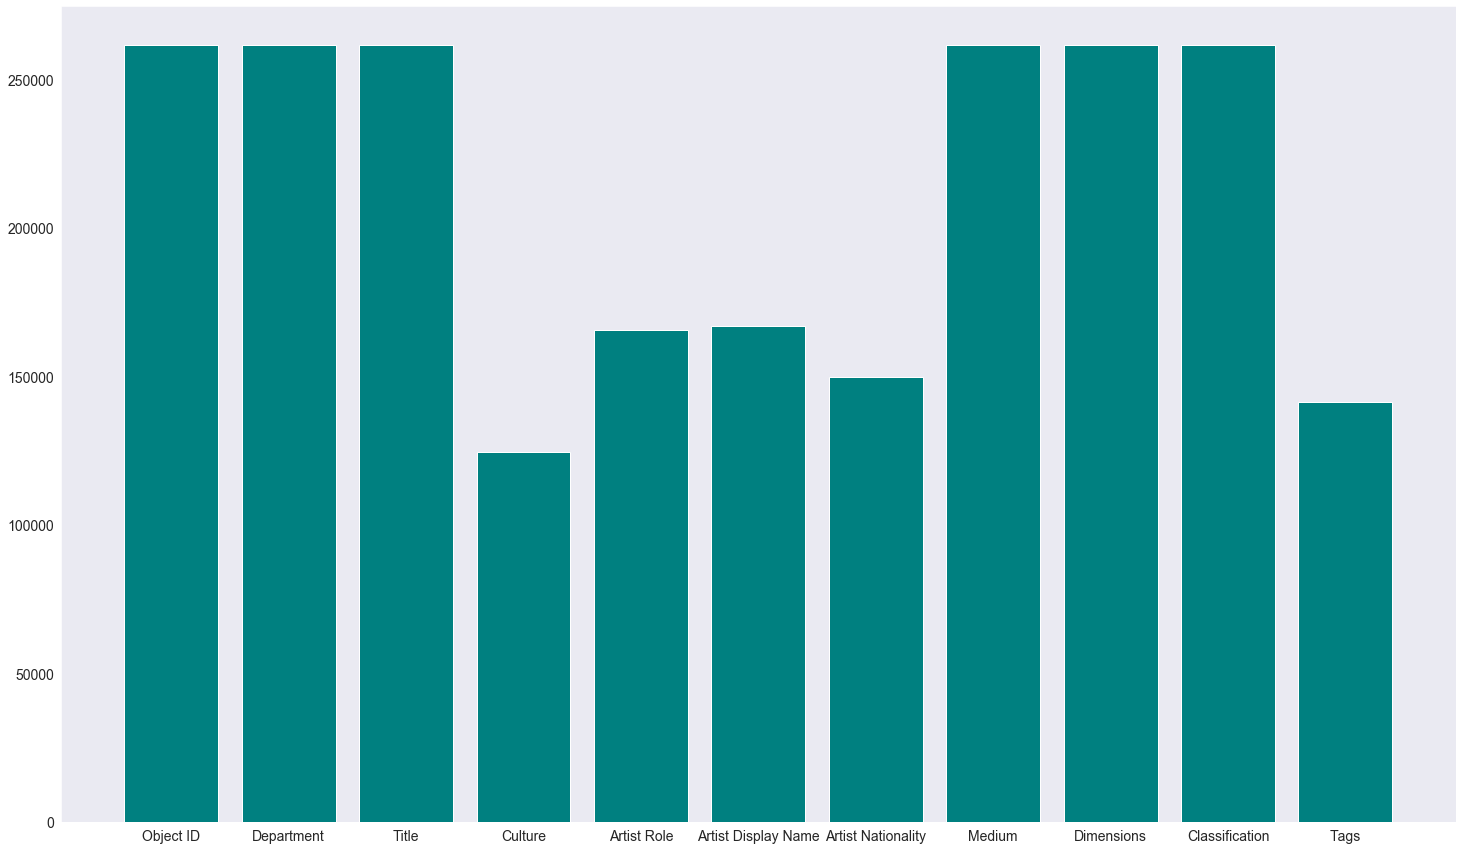

In [361]:
featCount = { i : 0 for i in textFeatures.keys() }
key_val_plotter(featCount, textFeatures)

In [362]:
pat = r"((^\(\?\))|[|\s\w])"
regexp = re.compile(pat)

In [370]:
# textFeatures = textFeatures.apply(lambda x : re.findall(regexp , str(x)) if re.findall(regexp , str(x)) else "UNKNOWN")
asdf = textFeatures.copy()
for key in asdf.keys():
    if key is not "Object ID":
        asdf[key] = asdf[key].apply(lambda x: str(x) if re.findall(regexp , ''.join(str(x))) else np.nan)
        asdf[key] = asdf[key].drop(asdf[asdf[key].isin(["|", "||"]) ].index)


asdf

,Object ID,Department,Title,Culture,Artist Role,Artist Display Name,Artist Nationality,Medium,Dimensions,Classification,Tags
0,1,The American Wing,One-dollar Liberty Head Coin,nan,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,nan
11,12,The American Wing,Twenty-dollar Liberty Head Coin,nan,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,nan
14,15,The American Wing,"Coin, 1/2 Real",Mexican,nan,nan,nan,Silver,Diam. 1/2 in. (1.3 cm),Silver,nan
15,16,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,nan,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,nan
16,17,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,nan,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,nan
...,...,...,...,...,...,...,...,...,...,...,...
473159,841569,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,nan,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,nan
473160,841570,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,nan,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,nan
473161,841571,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,nan,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,nan
473162,841572,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,nan,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,nan


In [369]:
asdf["Culture"].empty

False

Object ID <261595>
Department <261595>
Title <261595>
Culture <261595>
Artist Role <261559>
Artist Display Name <261595>
Artist Nationality <261595>
Medium <261595>
Dimensions <261594>
Classification <258927>
Tags <261595>


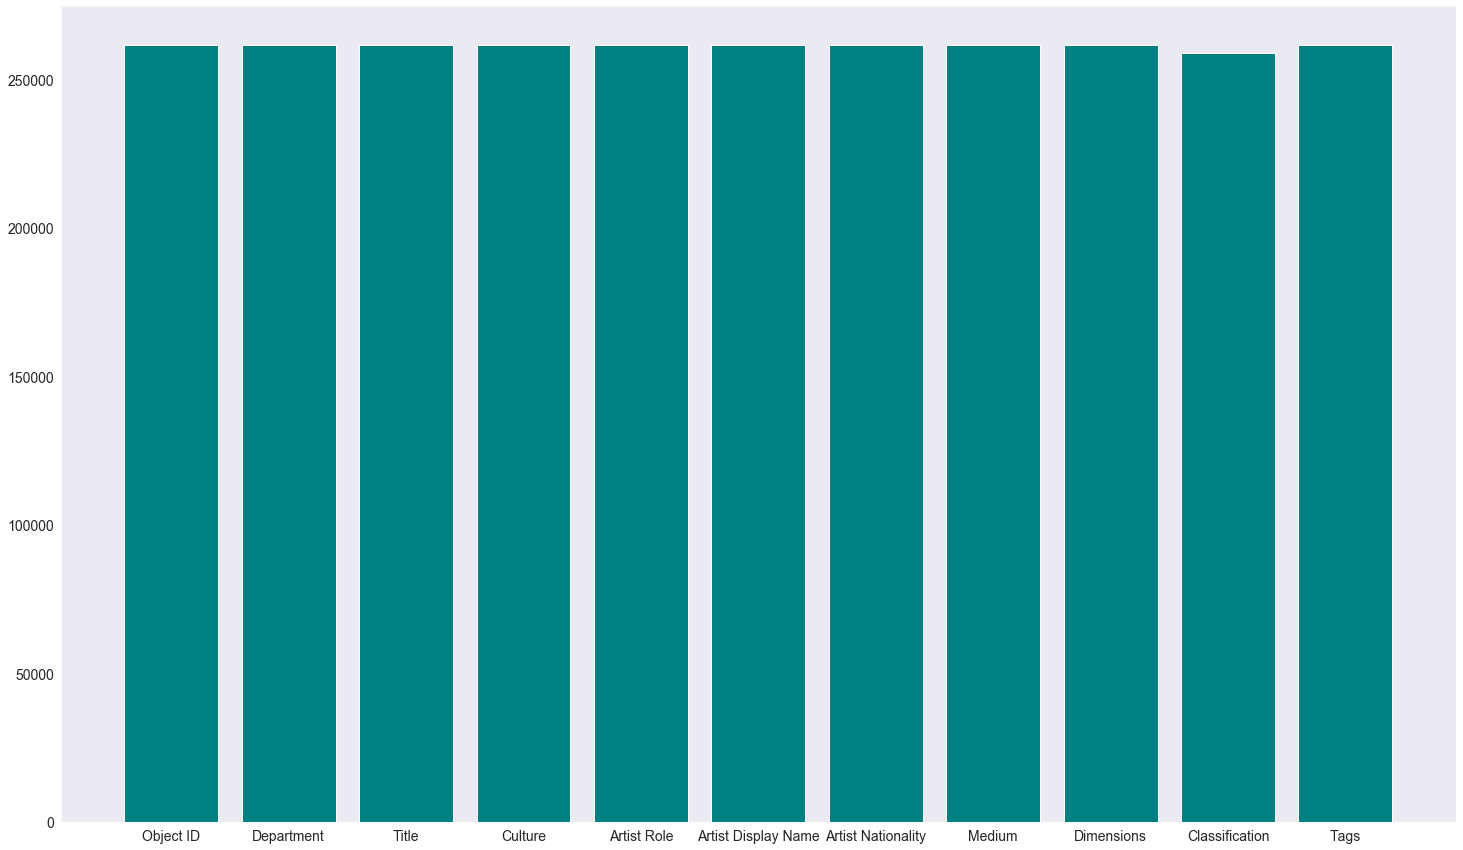

In [371]:
# asdf = asdf.dropna(how='any', subset=['Department', 'Title', 'Medium', 'Classification', 'Dimensions'])
# asdf = asdf.dropna(how='all', subset=['Culture', 'Artist Nationality'])
featCount = { i : 0 for i in asdf.keys() }
key_val_plotter(featCount, asdf)

In [247]:
s = pd.DataFrame({"asdf":asdf["Artist Role"].unique()})
# s[s["asdf"] == "||"]
s

,asdf
0,Maker
1,nan
2,Artist
3,Designer|Manufacturer
4,Designer|Maker
...,...
6504,Author|Purveyor
6505,Artist|Artist|Artist|Artist|Artist|Artist|Publ...
6506,Publisher|Subject|Subject|Subject|Subject|Subj...
6507,Publisher|Publisher|Artist|Artist|Publisher|Si...


## Numerical, Boolean, Date and Text Features joined as new dataset

In [372]:
dfs = [dirty[["Object ID", "Is Highlight", "Is Public Domain"]], dateFeatures, textFeatures]
cleanMet = reduce(lambda left,right: pd.merge(left,right,on='Object ID'), dfs)
cleanMet
# cleanMet.to_csv("n1.csv")

,Object ID,Is Highlight,Is Public Domain,Artist Begin Date,Artist End Date,Object Date,Object Begin Date,Object End Date,Metadata Date,Department,Title,Culture,Artist Role,Artist Display Name,Artist Nationality,Medium,Dimensions,Classification,Tags
0,1,False,False,1794,1869,1853,1853,1853,UNKNOWN,The American Wing,One-dollar Liberty Head Coin,NaN,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,NaN
1,12,False,False,1794,1869,1876,1876,1876,UNKNOWN,The American Wing,Twenty-dollar Liberty Head Coin,NaN,Maker,James Barton Longacre,American,Gold,Dimensions unavailable,Metal,NaN
2,15,False,False,UNKNOWN,UNKNOWN,1665–1700,1665,1700,UNKNOWN,The American Wing,"Coin, 1/2 Real",Mexican,NaN,NaN,NaN,Silver,Diam. 1/2 in. (1.3 cm),Silver,NaN
3,16,False,False,UNKNOWN,UNKNOWN,1800–1900,1800,1900,UNKNOWN,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,NaN,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,NaN
4,17,False,False,UNKNOWN,UNKNOWN,1867,1867,1867,UNKNOWN,The American Wing,"Coin, 1/4 Peso",Mexican,Artist,Mexican Artist,NaN,Bronze or copper,Diam. 1 1/8 in. (2.9 cm),Metal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261590,841569,False,True,1718,1779,ca. 1772,1767,1777,2020-02-04,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,NaN,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,NaN
261591,841570,False,True,1718,1779,ca. 1772,1767,1777,2020-02-04,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,NaN,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,NaN
261592,841571,False,True,1718,1779,ca. 1772,1767,1777,2020-02-04,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,NaN,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,NaN
261593,841572,False,True,1718,1779,ca. 1772,1767,1777,2020-02-04,European Sculpture and Decorative Arts,Side chair (one of a set of fourteen),British,Maker|Designer,Thomas Chippendale|Robert Adam,NaN,"Mahogany, covered in modern red morocco leather",Overall (each): 38 1/4 × 22 × 22 1/2 in. (97.2...,Woodwork-Furniture,NaN


Object ID <261595>
Is Highlight <261595>
Is Public Domain <261595>
Artist Begin Date <261595>
Artist End Date <261595>
Object Date <255211>
Object Begin Date <261595>
Object End Date <261595>
Metadata Date <261595>
Department <261595>
Title <261595>
Culture <124688>
Artist Role <165789>
Artist Display Name <166937>
Artist Nationality <149955>
Medium <261595>
Dimensions <261595>
Classification <261595>
Tags <141459>


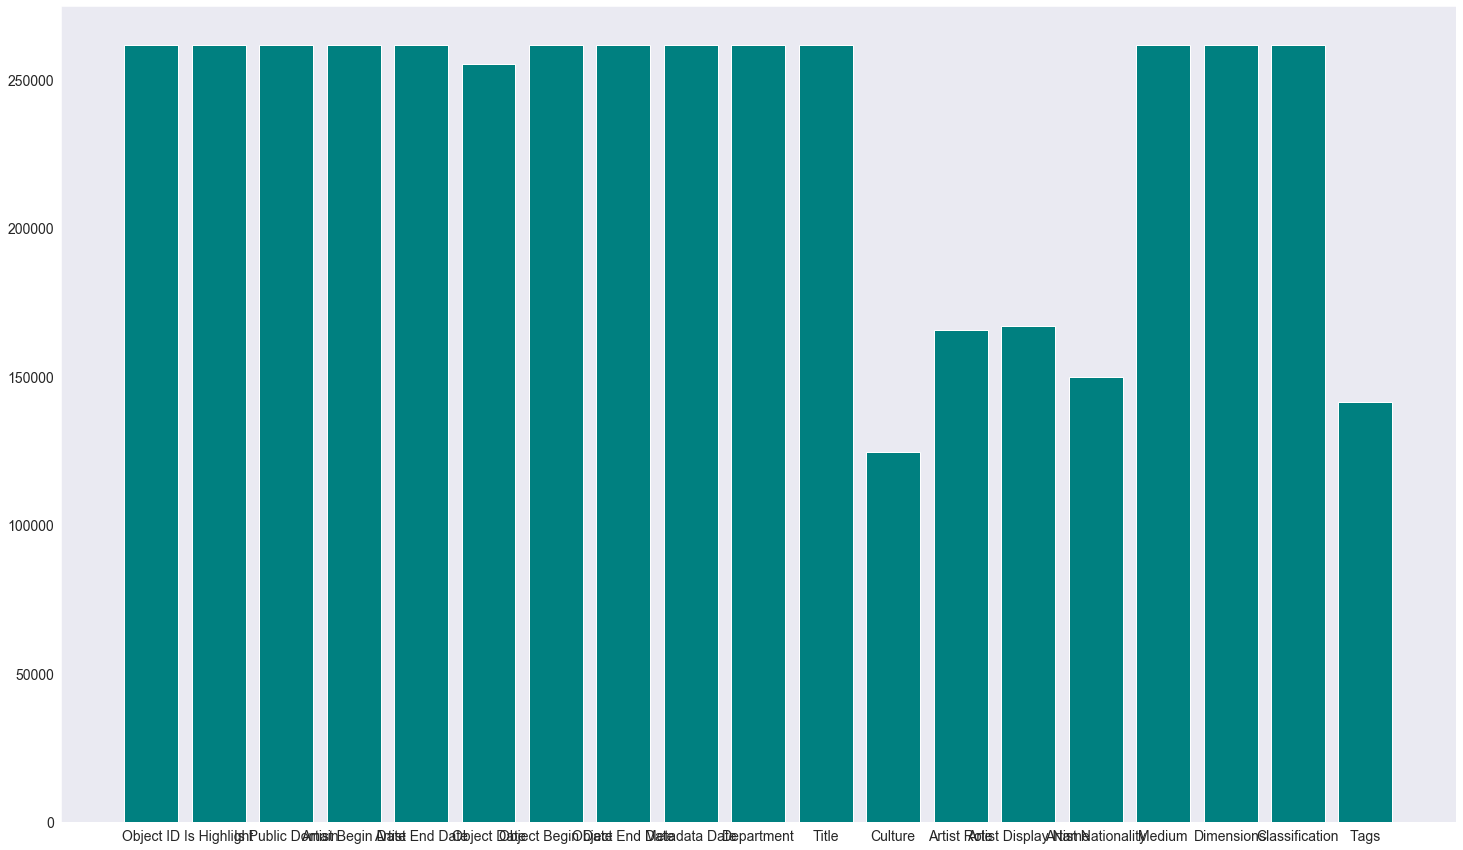

In [381]:
featCount = { i : 0 for i in cleanMet.keys() }
key_val_plotter(featCount, cleanMet)

In [328]:
localFeatures = dirty[localColumns].copy()
localFeatures

,Object ID,City,State,County,Country,Region,Subregion,Locale,Locus,Excavation,River
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
473765,843221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473766,843222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473767,843223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473768,843227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


31756
2519
8244
75106
31299
22025
15561
7353
15985
2096


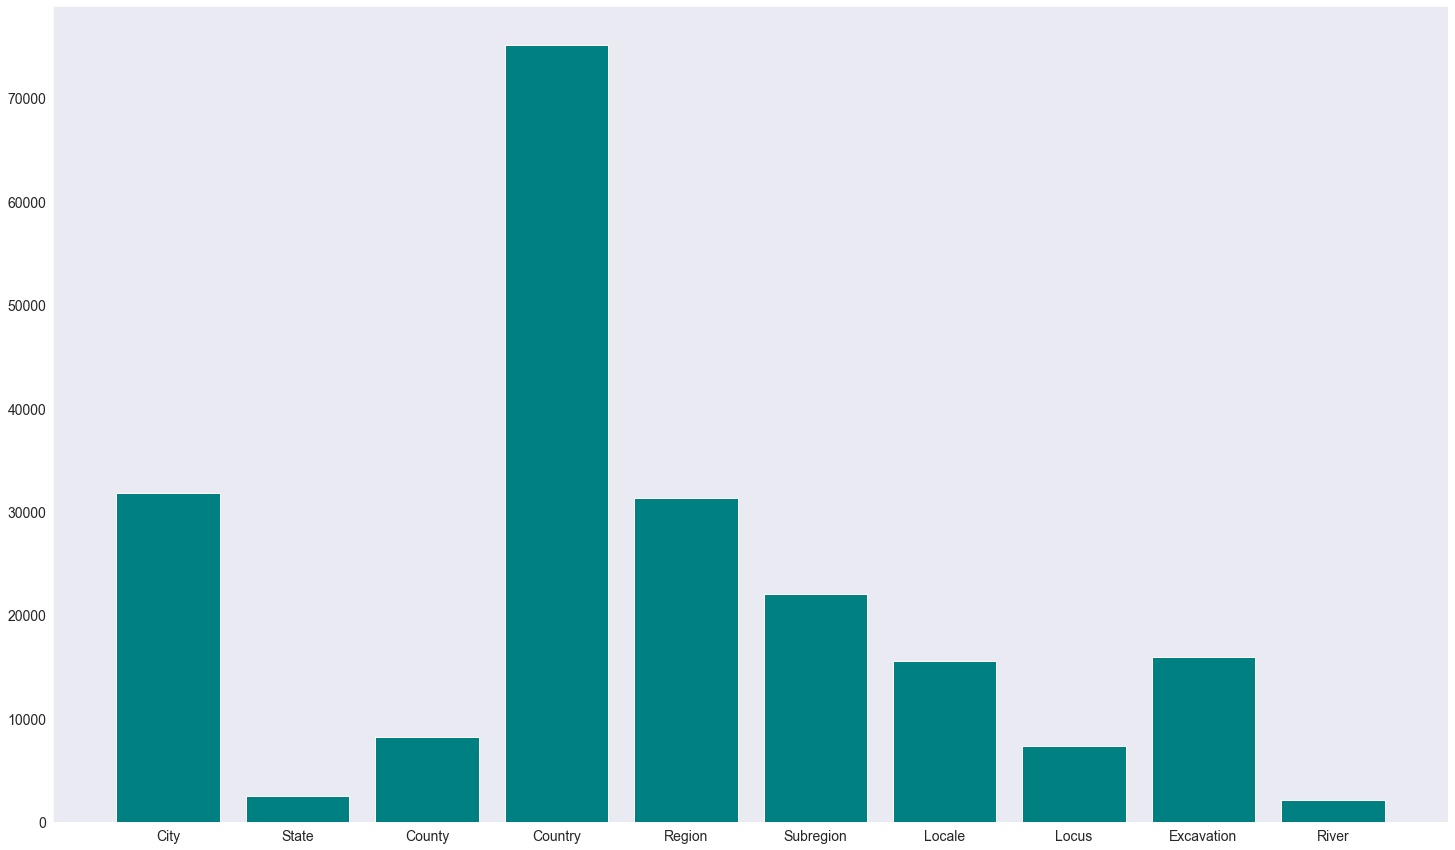

In [329]:
localFeatures = localFeatures.drop(columns=["Object ID"])
featCount = { i : 0 for i in localFeatures.keys() }
key_val_plotter(featCount, localFeatures)

In [15]:
# sum(map(len, unquies.values()))

963878